## **Автоматическая правильная линия**

#### Описание
Данная автоматическая правильная линия (АПЛ) предназначена для правки сортового проката, т.е. достижения требуемой кривизны. В связи оптимизацией работы данной линии, а именно, повышение процента точности правки с "первого" раза, разрабатывается решение на основе машинного обучения.
Целью проекта является выявление закономерностей признаков, обучение на исходных данных для формирования начального воздействия и вывод модели в продакшен.

#### Для анализа и хранения данных используем следующие ПО:
1. Аналитическая платформа Knime
2. VSCode (Python)
3. IBA HD (БД технологических параметров)
4. PostgreSQL (БД технологических параметров)

#### Описание процесса:
1. *Сбор данных*
    - Формирование данных в PLC оборудования, PLC статистики для конкретного оборудования или определенной группы.
    - Фиксация и хранение данных:
        - программное обеспечение IBA PDA -> БД IBA HD
        - программное обеспечение driverX -> БД PostgreSQL
        - специализированный шлюз (Python) -> БД PostgreSQL
        - выгрузка данных в csv -> Файл
    - Чтение данных из разных источников:
        - БД IBA HD -> API для С#, Python
        - БД PostgreSQL -> Аналитическая платформа Knime, Python
        - Файл -> Аналитическая система Knime, Python
2. *Обзор данных*
3. *Подготовка данных*
4. *Разведывательный анализ данных*
5. *Преобразование данных*
6. *Построение модели*
7. *Вывод модели в продакшен*

## 1. Сбор данных
Сбор данных осуществляется в автоматическом режиме посредством шлюза "сбора данных". Реализована связка OPC сервер + шлюз Phyton + база данных PostgreSQL.

Для анализа данные выгружены в файл csv.

##### Описание признаков
- dt - временная метка записи
- is_del - признак "строка удалена"  
- bar - идентификатор заготовки
- curvature - исходная, измеренная кривизна
- action - воздействие на гидроцилиндр (перемещение в мм)
- out_curvature - выходная кривизна после воздействия
- length_bar - участок заготовки, на которой было воздействие
- first_correct - успешная корректировка кривизны после первого воздействия
- upper_bound - допуск на [+]
- lower_bound - допуск на [-]
- nomen - входная номенклатура
- n_plav - номер плавки
- n_packet - номер пакета
- dt_action - время правки
- С - содержание углерода в марке стали
- Si - содержание кремния в марке стали
- V - содержание ванадия в марке стали
- Mn - содержание марганца в марке стали
- characteristic - характеристика номенклатуры

## 2. Обзор данных

In [1]:
# загрузка используемых библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import optuna
import pickle
from sklearn.pipeline import Pipeline
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn.preprocessing import QuantileTransformer #трансформация данных
from sklearn.ensemble import RandomForestRegressor #RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor #DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error #метрики
from sklearn import model_selection #методы разделения и валидации

RANDOM_NUM = 87

In [2]:
# чтение исходных данных
data = pd.read_csv('d:/Curvature_Analysis_CLN/apl_od.csv',  sep=';')
df = data.copy()

# набор данных для анализа начальной кривизны
df_initial_curvature = data.copy()

df.head(2)

dt  is_del    bar  curvature    action  \
0  2022-12-04T17:45:26.979311       0  59852   0.420701 -0.260350   
1  2022-12-04T17:44:43.507137       0  59851   0.166726 -0.139602   

   out_curvature  length_bar  first_correct  upper_bound  lower_bound nomen  \
0      -0.111312         660              0         0.12        -0.12  Т70А   
1      -0.004104        3850              1         0.12        -0.12  Т70А   

     n_plav n_packet                dt_action      C     Si       V     Mn  \
0  ПТ2008-2     899А  2022-12-04T17:39:21.606  0.192  0.182  0.0023  0.512   
1  ПТ2008-2     899А  2022-12-04T17:39:12.612  0.192  0.182  0.0023  0.512   

   characteristic  
0               3  
1               3

In [3]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571623 entries, 0 to 571622
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dt              571623 non-null  object 
 1   is_del          571623 non-null  int64  
 2   bar             571623 non-null  int64  
 3   curvature       571623 non-null  float64
 4   action          571623 non-null  float64
 5   out_curvature   571623 non-null  float64
 6   length_bar      571623 non-null  int64  
 7   first_correct   571623 non-null  int64  
 8   upper_bound     571623 non-null  float64
 9   lower_bound     571623 non-null  float64
 10  nomen           571606 non-null  object 
 11  n_plav          571623 non-null  object 
 12  n_packet        571623 non-null  object 
 13  dt_action       571623 non-null  object 
 14  C               571623 non-null  float64
 15  Si              571623 non-null  float64
 16  V               571623 non-null  float64
 17  Mn        

In [4]:
# статистические данные
df.describe()

is_del            bar      curvature         action  \
count  571623.000000  571623.000000  571623.000000  571623.000000   
mean        0.011229   59924.561405      -0.003561       0.300834   
std         0.105372   31395.041074       0.303055       2.573331   
min         0.000000       1.000000      -3.410945      -5.919511   
25%         0.000000   33318.000000      -0.215486      -2.421834   
50%         0.000000   64885.000000      -0.118998       0.356828   
75%         0.000000   84685.000000       0.209242       2.611410   
max         1.000000  111470.000000       2.943279       6.000000   

       out_curvature     length_bar  first_correct    upper_bound  \
count  571623.000000  571623.000000  571623.000000  571623.000000   
mean        0.041462    2637.002348       0.635924       0.113595   
std        27.180902    1614.503922       0.481170       0.008081   
min        -1.739527      10.000000       0.000000       0.090000   
25%        -0.079885    1170.000000       0.000000       0.110000   
50%         0.005743    2660.000000       1.000000       0.120000   
75%         0.090433    3850.000000       1.000000       0.120000   
max     20550.030000  273033.000000       1.000000       0.200000   

         lower_bound              C             Si              V  \
count  571623.000000  571623.000000  571623.000000  571623.000000   
mean       -0.113595       0.183114       0.185913       0.004278   
std         0.008082       0.026166       0.013691       0.003771   
min        -0.220000       0.069000       0.119000       0.000900   
25%        -0.120000       0.184000       0.180000       0.002300   
50%        -0.120000       0.188000       0.188000       0.003000   
75%        -0.110000       0.194000       0.194000       0.004600   
max        -0.090000       0.527000       0.224000       0.092100   

                  Mn  characteristic  
count  571623.000000   571623.000000  
mean        0.566869        4.177668  
std         0.044986        0.986267  
min         0.348000        3.000000  
25%         0.567000        3.000000  
50%         0.576000        5.000000  
75%         0.585000        5.000000  
max         0.840000       10.000000

Из описательной статистики видим:
- присутствие данных "помеченных на удаление" [is_del], 
- аномалии по начальной кривизне [out_curvature], 
- аномалии по остаточной кривизне [out_curvature], 
- аномалии по определению точки воздействия [lenght_bar], 
- недопустимые значения по углероду для данных марок стали.


Так как на уровне системы управления прессом, мы видим направление правки, то данные признаков ['curvature', 'action', 'out_curvature'] можно взять по модулю.

Трансформируем наш набор данных.

## 3. Подготовка данных

#### Начальная обработка данных

In [5]:
# # Взятие признаков ['curvature', 'action', 'out_curvature'] по модулю
def s_abs(df, s): # список
    X = df.copy()
    for i in s:
        if X[i].dtype == float or X[i].dtype == int:
            X[i] = np.abs(X[i])
    return X

df = s_abs(df, ['curvature', 'action', 'out_curvature'])

def df_transformation(df, mask):   
    X = df.copy()
    X = X[mask]
    print (f'Исходный набор данных: {df.shape}')
    print (f'Трансформированный набор: {X.shape}')
    return X

# преобразуем данные формат dt
df['_dt'] = pd.to_datetime(df['dt'])

# Накладываем фильтр
# 1. оставляем все, где is_del = false 
# 2. берем только те воздействия, где выправили с 1 раза
# 3. берем только воздействия больше 1.0 мм и меньше 3.9 мм
#    [action] > 1.0 мм 
# 4. Очищаем данные по хим. элементам, где от превышает это число считаем недостоверными
#    [C] < 0.3 и [C] > 0.1
# 5. Отбрасываем данные по длине заготовки, где
#    [length_bar] > 300 и [length_bar] < 5000
# 6. Удаляем данные где номенклатура не определена
#    [nomen] == ''
# 7. исходная кривизна меньше 1 мм
#    [curvature] < 1.0 мм
# 8. воздействие при малой начальной кривизне, не может быть больше 2.0 мм
#    [curvature] < 0.12 мм & [action] > 2.0 мм

mask = (df['is_del'] == 0) & \
       (df['first_correct'] == 1) & \
       ((df['action'] > 1.0) & (df['action'] < 3.9)) &\
       ((df['C'] > 0.05) & (df['C'] < 0.3)) & \
       ((df['length_bar'] > 300) & (df['length_bar'] < 5000)) & \
       (df['nomen'] != '') & \
       ((df['curvature'] < 1.0)) & \
       (((df['curvature'] < 0.12) & (df['action'] < 2.0)) | ((df['curvature'] >= 0.12) & (df['action'] > 0.4)))
       
df_tr = df_transformation(df, mask)


# Удаляем признаки, не влияющие на воздействие
s = ['bar', 'out_curvature', 'first_correct', 'length_bar', 'upper_bound', 'lower_bound', 
     'dt', 'is_del', 'n_plav', 'n_packet', 'dt_action', 'characteristic']
df_drop = df_tr.drop(s, axis=1).reset_index(drop=True)

Исходный набор данных: (571623, 20)
Трансформированный набор: (290667, 20)


#### Зависимость начальной кривизны и воздействия

Text(0.5, 1.0, 'Зависимость воздействия от кривизны')

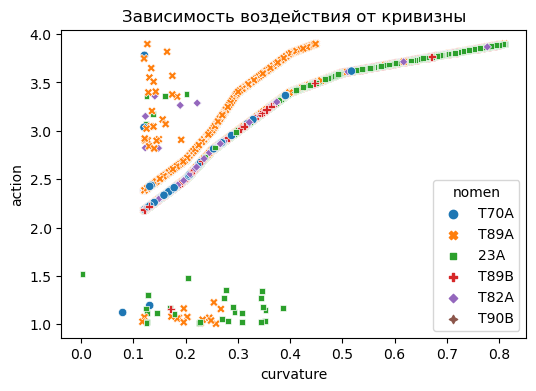

In [6]:
fig = plt.figure(figsize=(6, 4))
sn = sns.scatterplot(
    data=df_drop,
    y='action',
    x='curvature',
    hue='nomen',
    style='nomen'
    )
sn.set_title('Зависимость воздействия от кривизны')

На графике виден ярко выраженный шум.

Исходный набор данных: (290667, 8)
Трансформированный набор: (290282, 8)


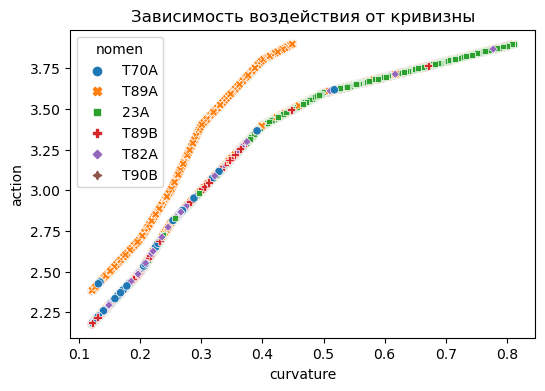

In [7]:
# Удалим шум
mask1 = (((df_drop['curvature'] < 0.21) & (df_drop['action'] > 2.75)) | \
        ((df_drop['curvature'] < 0.23) & (df_drop['action'] > 3)) | \
        ((df_drop['curvature'] < 0.4) & (df_drop['action'] < 1.7))
       )         
df_drop = df_transformation(df_drop, ~mask1)

fig = plt.figure(figsize=(6, 4))
sn = sns.scatterplot(
    data=df_drop,
    y='action',
    x='curvature',
    hue='nomen',
    style='nomen'
    )
sn.set_title('Зависимость воздействия от кривизны')

s = ['_dt']
df_drop = df_drop.drop(s, axis=1).reset_index(drop=True)

## 4. Разведывательный анализ данных

In [8]:
# количество уникальных номенклатур в наборе данных
print(df_drop['nomen'].value_counts().unique)

<bound method Series.unique of 23А     126309
Т89А     83141
Т82А     42355
Т70А     26115
Т89В      6971
Т90В      5385
Name: nomen, dtype: int64>


array([[<AxesSubplot: title={'center': 'curvature'}>,
        <AxesSubplot: title={'center': 'action'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'Si'}>],
       [<AxesSubplot: title={'center': 'V'}>,
        <AxesSubplot: title={'center': 'Mn'}>]], dtype=object)

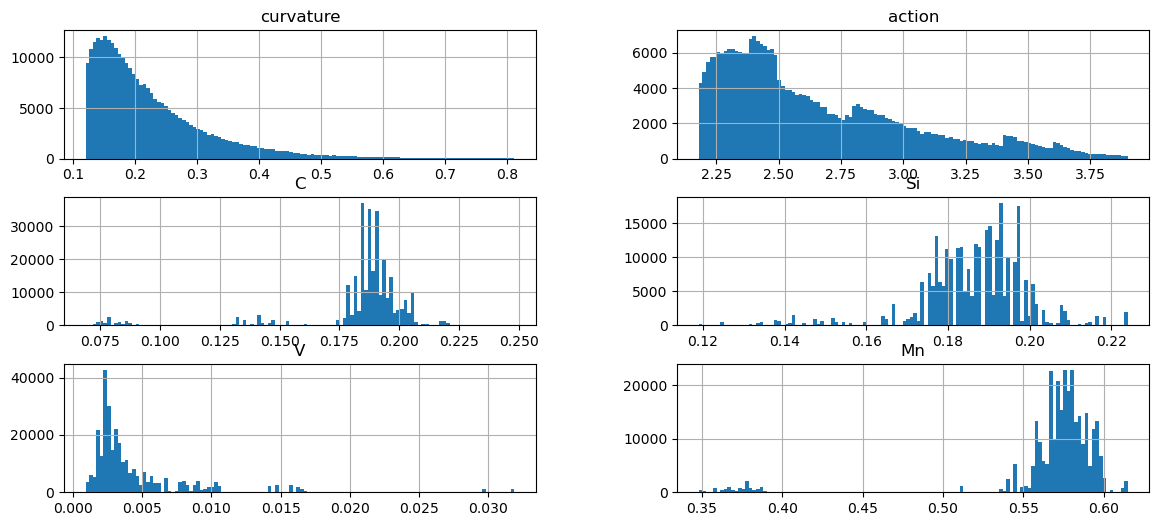

In [9]:
# Частотное распределение признаков
df_drop.hist(bins=120, figsize=(14, 6))

In [10]:
# Выполнение теста на нормальность
# Формулировка нулевой и альтернативной гипотез
from scipy import stats

H0 = 'Распределение признака action является нормальным'
H1 = 'Распределение признака action отлично от нормального'

# Уровень значимости
alpha = 0.05

# Выполнение теста Д'Агостино
d_agostino = stats.normaltest(df_drop['action'])

if d_agostino.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Отвергаем нулевую гипотезу. Распределение признака action является нормальным
Альтернативная гипотеза. H1: Распределение признака action отлично от нормального


#### Анализ начальной кривизны

In [11]:
mask = (df['is_del'] == 0) & \
       (df['action'] > 0.4) & \
       ((df['C'] > 0.05) & (df['C'] < 0.3)) & \
       ((df['length_bar'] > 300) & (df['length_bar'] < 5000)) & \
       (df['nomen'] != '') & \
       (df['curvature'] < 1.0)    
df_initial_curvature = df_transformation(data, mask)
s = ['dt', 'is_del', 'upper_bound', 'lower_bound', 'C', 'Si', 'V', 'Mn',
     'first_correct']
df_initial_curvature = df_initial_curvature.drop(s, axis=1).reset_index()

Исходный набор данных: (571623, 19)
Трансформированный набор: (474986, 19)


<AxesSubplot: xlabel='length_bar', ylabel='curvature'>

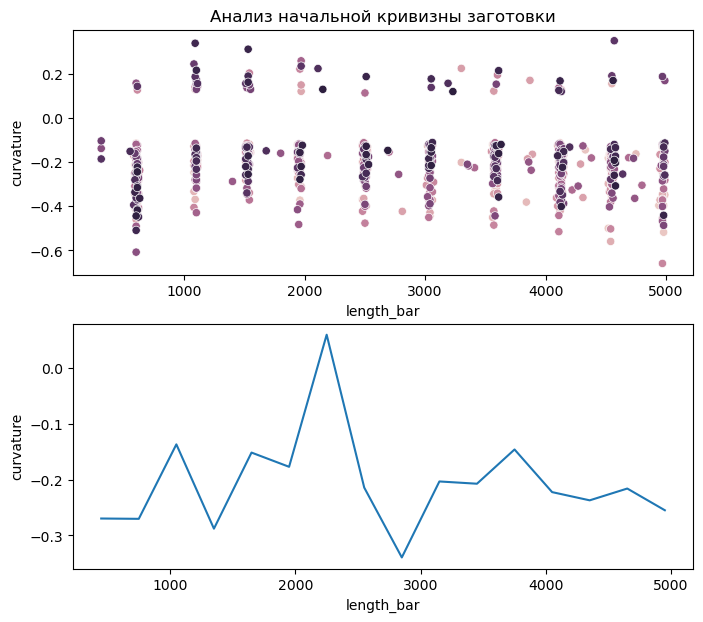

In [12]:
step = 500
max_length = 5000

def le(x):  
    ran = max_length / step;
    for i in range(1, int(ran) + 1):
        st = step*i
        if x <= st:
             y = st / 2
             break
        elif x > st and x <= st + step:
             y = st + step/2
             break
    return y

maska = (df_initial_curvature['n_packet'] == '1209') # 1209 - номер пакета
ddf = df_initial_curvature[maska].sort_values(by=['bar'])
ddf['dt'] = pd.to_datetime(ddf['dt_action'])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 7))
sn = sns.scatterplot(
    data=ddf,
    x='length_bar',
    y='curvature',
    hue='bar',
    legend=False,
    ax=axes[0]
    )
sn.set_title('Анализ начальной кривизны заготовки')

step = 300
max_length = 5000
ddf['gr'] = ddf['length_bar'].apply(le)

# из каждой заготовки берем среднее по кривизне
ddfg = ddf.groupby(['gr']).agg({'curvature': ['mean']}).reset_index()
ddfg.columns = ddfg.columns.droplevel(0)
ddfg = ddfg.rename(columns={'':'length_bar', 'mean': 'curvature'})

sns.lineplot(
    data=ddfg,
    x='length_bar',
    y='curvature',
    ax=axes[1]
    )

Анализ данного параметра даёт представление о настройке правильной машины перед правкой на прессе.
В данном случае (пакет №1209) машина настроена на минус, т.к. большинство значений начальной кривизны меньше 0.
Для учитывания данного параметра в модели требуется установка дополнительных лазерных датчиков.

## 5. Преобразование данных

#### Анализ пропусков в данных.

curvature    0
action       0
nomen        6
C            0
Si           0
V            0
Mn           0
dtype: int64


<AxesSubplot: >

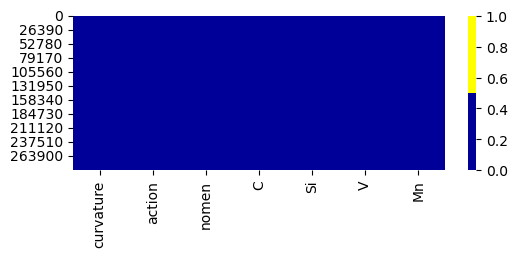

In [13]:
# количество пропусков данных в признаках
print (df_drop.isnull().sum())

# Тепловая карта пропущенных значений
cols = df_drop.columns[:]
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 

fig = plt.figure(figsize=(6, 2))
sns.heatmap(df_drop[cols].isnull(), 
            cmap=sns.color_palette(colours))

In [14]:
# Удаляем пропуски
df_drop = df_drop.dropna().reset_index(drop=True)
print (df_drop.isnull().sum())

curvature    0
action       0
nomen        0
C            0
Si           0
V            0
Mn           0
dtype: int64


#### Преобразование категориальных признаков

In [15]:
# Преобразуем категориальные признаки
# кодирование признаков OneNotEncoder 
df_encoder = pd.get_dummies(df_drop)
df_encoder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290276 entries, 0 to 290275
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   curvature   290276 non-null  float64
 1   action      290276 non-null  float64
 2   C           290276 non-null  float64
 3   Si          290276 non-null  float64
 4   V           290276 non-null  float64
 5   Mn          290276 non-null  float64
 6   nomen_23А   290276 non-null  uint8  
 7   nomen_Т70А  290276 non-null  uint8  
 8   nomen_Т82А  290276 non-null  uint8  
 9   nomen_Т89А  290276 non-null  uint8  
 10  nomen_Т89В  290276 non-null  uint8  
 11  nomen_Т90В  290276 non-null  uint8  
dtypes: float64(6), uint8(6)
memory usage: 14.9 MB


#### Удаление дубликатов

In [16]:
# удаление дубликатов
def drop_duplicates(df):  
    key = df.columns
    X = df.drop_duplicates(subset=key)
    print(f'Оригинальный датасет: {df.shape}')
    print(f'Датасет после удаления дупликатов: {X.shape}')
    return X

df_dd = drop_duplicates(df_encoder)

Оригинальный датасет: (290276, 12)
Датасет после удаления дупликатов: (259998, 12)


#### Работа с выбросами

In [17]:
def outliers_iqr_mod(data, feature, log_scale=False, left=1.5, right=1.5):
    """
    Параметры left и right, которые задают число IQR влево и вправо 
    от границ ящика (по умолчанию они равны 1.5).
    Функция возвращает потенциальные выбросы и очищенный DataFrame.
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]   
    #x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'[{feature}] log_scale:[{log_scale}] left, right=[{left}, {right}] выбросов по методу Тьюки: {outliers.shape[0]} число записей: {cleaned.shape}')
    return outliers, cleaned

def outliers_z_score_mod(data, feature, log_scale=False, left=3, right=3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'[{feature}] log_scale:[{log_scale}] left, right=[{left}, {right}] выбросов по методу z-отклонения: {outliers.shape[0]} число записей: {cleaned.shape}')
    return outliers, cleaned

In [18]:
columns = df_dd.columns
for col in columns:      
    df_outliers_sigma, df_cleaned_sigma = outliers_z_score_mod(df_dd, col, False, 3, 3)

[curvature] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 4876 число записей: (255122, 12)
[action] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 531 число записей: (259467, 12)
[C] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 11026 число записей: (248972, 12)
[Si] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 6042 число записей: (253956, 12)
[V] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 5841 число записей: (254157, 12)
[Mn] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 11026 число записей: (248972, 12)
[nomen_23А] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 0 число записей: (259998, 12)
[nomen_Т70А] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 23441 число записей: (236557, 12)
[nomen_Т82А] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 0 число записей: (259998, 12)


In [19]:
columns = df_dd.columns
for col in columns:      
    df_outliers_iqr, df_cleaned_iqr = outliers_iqr_mod(df_dd, col, False, 1.5, 1.5)

[curvature] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 11759 число записей: (248239, 12)
[action] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 3341 число записей: (256657, 12)
[C] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 27539 число записей: (232459, 12)
[Si] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 13566 число записей: (246432, 12)
[V] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 21959 число записей: (238039, 12)
[Mn] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 14032 число записей: (245966, 12)
[nomen_23А] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 0 число записей: (259998, 12)
[nomen_Т70А] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 23441 число записей: (0, 12)
[nomen_Т82А] log_scale:[False] left, right=[1.5, 1.5] выбросов по методу Тьюки: 32348 число записей: (0, 12)
[nomen_Т89А] log_scale:[False

In [20]:
# Удалим выбросы из признаков [curvature]
# curvature
col = 'curvature'
dfX = df_dd
df_outliers_sigma, df_cleaned_sigma = outliers_z_score_mod(dfX, col, False, 3, 3)
df_cleaned = df_cleaned_sigma

# action
col = 'action'
dfX = df_cleaned
df_outliers_sigma, df_cleaned_sigma = outliers_z_score_mod(dfX, col, False, 3, 3)
df_cleaned = df_cleaned_sigma

# reset_index
df_cleaned = df_cleaned.reset_index(drop=True)

[curvature] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 4876 число записей: (255122, 12)
[action] log_scale:[False] left, right=[3, 3] выбросов по методу z-отклонения: 793 число записей: (254329, 12)


<AxesSubplot: >

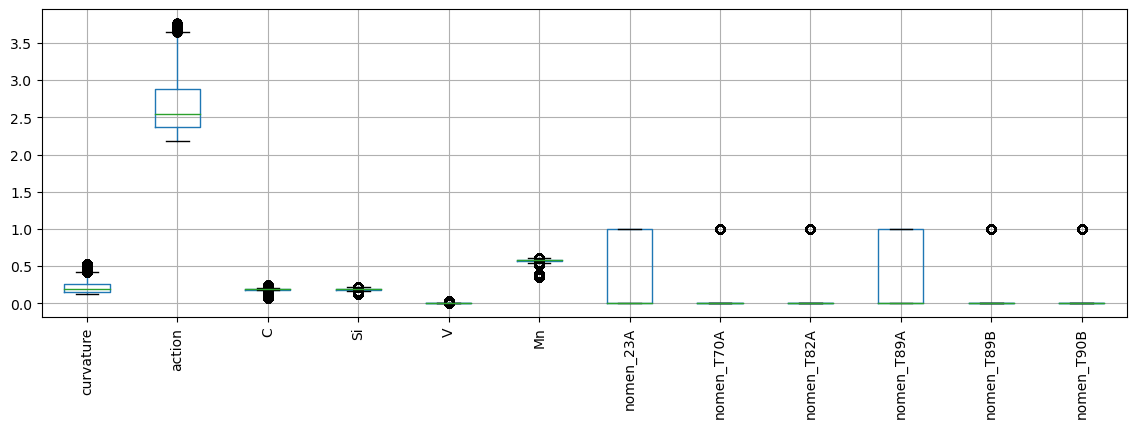

In [21]:
# построим коробчатую диаграмму
df_cleaned.boxplot(figsize=(14, 4), rot=90)

##### Матрица корреляций

<AxesSubplot: >

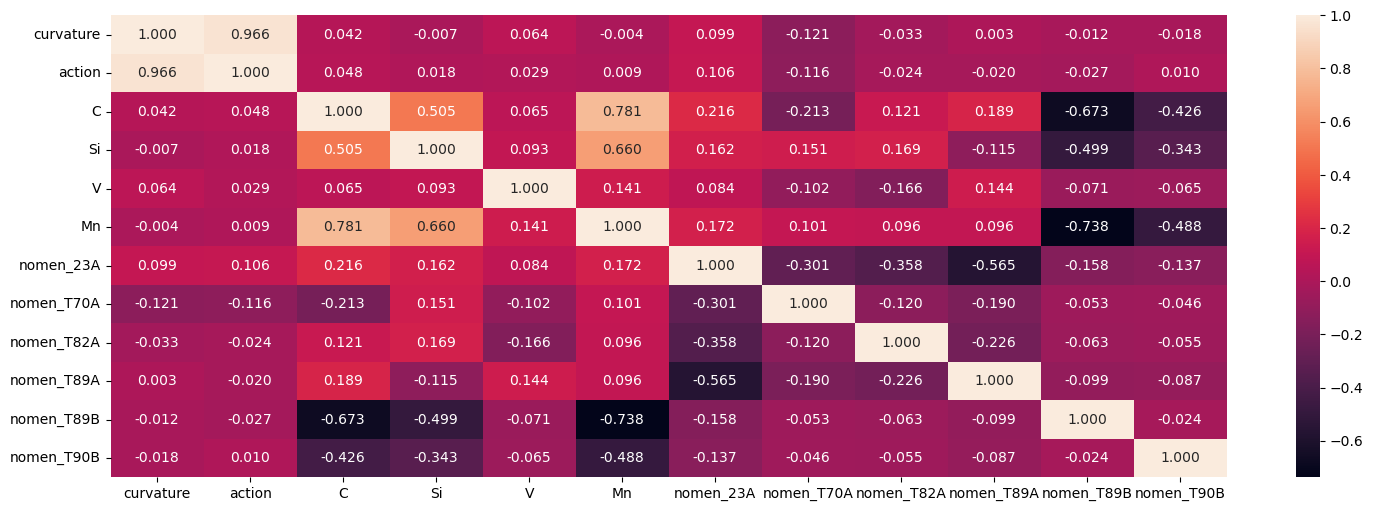

In [22]:
# строим матрицу корреляций
fig = plt.figure(figsize=(18, 6))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".3f")

In [23]:
profile = ProfileReport(df_cleaned, title="")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# сохраним датасет
df_cleaned.to_csv('d:/Curvature_Analysis_CLN/df_cleanedXsk.csv', sep=';', index=False)

## 6. Построение модели

In [25]:
# чтение исходных данных
df_clea = pd.read_csv('d:/Curvature_Analysis_CLN/df_cleanedXsk.csv',  sep=';')
df_clea.head(2)

curvature    action      C     Si       V     Mn  nomen_23А  nomen_Т70А  \
0   0.378441  3.313766  0.192  0.182  0.0023  0.512          0           1   
1   0.233154  2.698922  0.192  0.182  0.0023  0.512          0           1   

   nomen_Т82А  nomen_Т89А  nomen_Т89В  nomen_Т90В  
0           0           0           0           0  
1           0           0           0           0

##### Нормализация данных

In [26]:
dff = df_clea.copy()

# стандартизация
def StScaler(df):
    s_scaler = preprocessing.StandardScaler()
    scaler = s_scaler.fit_transform(df)
    df_s = pd.DataFrame(scaler, columns=list(df.columns))
    return df_s

# нормализация
# minmaxscaler
# x_scaled = (x - x_min) / (x_max - x_min)
# x = x_scaled*(x_max - x_min) + x_min
def MMScaler(df):
    mm_scaler = preprocessing.MinMaxScaler()
    scaler = mm_scaler.fit_transform(df)
    df_mm = pd.DataFrame(scaler, columns=list(df.columns))
    return df_mm

# robustscaler
# x_scaled = (x - median) / IQR
# x = (x_scaled*IQR) + median
def RScaler(df):
    r_scaler = preprocessing.RobustScaler()
    scaler = r_scaler.fit_transform(df)
    df_r = pd.DataFrame(scaler, columns=list(df.columns)) 
    return df_r

# стандартизация
df_out_stsc = StScaler(dff)
# нормализация
df_out_mmsc = MMScaler(dff)
df_out_rsc = RScaler(dff)

# функции для преобразования для MinMaxScaler
def reverse_conversion_MinMaxScaler(scaled_value, feature, mi, ma):
    val = (scaled_value*(ma[feature] - mi[feature])) + mi[feature]
    return val
def conversion_MinMaxScaler(value, feature, mi, ma):
    val = (value - mi[feature]) / (ma[feature] - mi[feature])
    return val

В построении модели будем использовать нормализированные данные по методу MinMaxScaler

Text(0.5, 1.0, 'Распределения после MinMaxScaler')

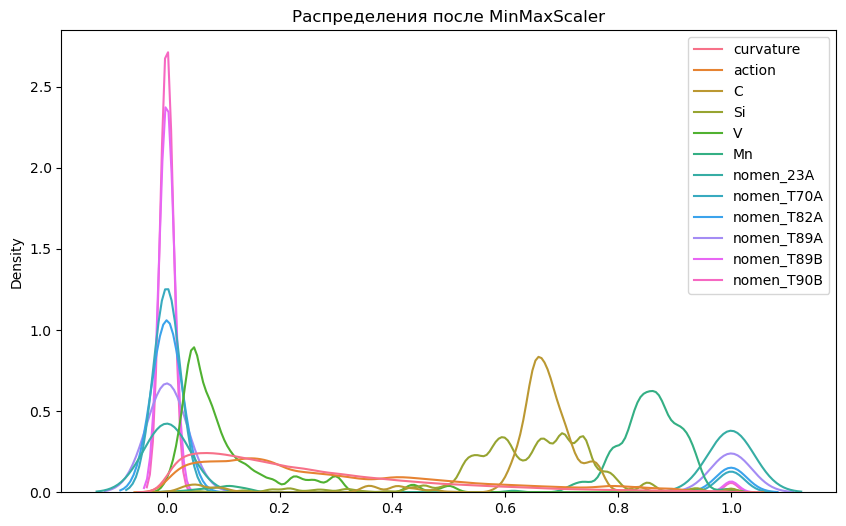

In [27]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.kdeplot(
    data=df_out_mmsc,
    ax=ax
    )
ax.set_title('Распределения после MinMaxScaler')

Разделим данные на обучающую и тестовую выборку.

In [28]:
cols = ['action']
X = df_out_mmsc.drop(cols, axis = 1)
y = df_out_mmsc['action']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=RANDOM_NUM
    )

print(f' Размерность обучающей выборки {X_train.shape}')
print(f' Размерность тестовой выборки {X_test.shape}')

 Размерность обучающей выборки (203463, 11)
 Размерность тестовой выборки (50866, 11)


In [29]:
# метрики
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print(f'R^2 Train:{round(metrics.r2_score(y_train, y_train_predict), 4)} ' \
          f'Test:{round(metrics.r2_score(y_test, y_test_predict), 4)}')
    print(f'MAE Train:{round(metrics.mean_absolute_error(y_train, y_train_predict), 4)} ' \
          f'Test:{round(metrics.mean_absolute_error(y_test, y_test_predict), 4)}')
    print(f'MSE Train:{round(mean_squared_error(y_train, y_train_predict), 4)} ' \
          f'Test:{round(mean_squared_error(y_test, y_test_predict), 4)}')
    print(f'RMSE Train:{round(np.sqrt(mean_squared_error(y_train, y_train_predict)), 4)} ' \
          f'Test:{round(np.sqrt(mean_squared_error(y_test, y_test_predict)), 4)}')

Для анализа возмем 3 модели DecisionTreeRegressor, RandomForestRegressor и GradientBoostingRegressor.

In [30]:
# DecisionTreeRegressor
params_dtr = {'max_depth':10,
              'criterion':'squared_error',
              'max_leaf_nodes':10,
              'min_samples_leaf':1, 
              'min_samples_split':2, 
              'random_state':RANDOM_NUM 
             }
dtr = DecisionTreeRegressor(**params_dtr)
dtr.fit(X_train.values, y_train)
dtr_train_pred = dtr.predict(X_train.values)
dtr_test_pred = dtr.predict(X_test.values)

# RandomForestRegressor
params_rfr = {'n_estimators':10,
              'max_depth':10,
              'criterion':'squared_error',
              'max_leaf_nodes':10,
              'min_samples_leaf':1, 
              'min_samples_split':2, 
              'random_state':RANDOM_NUM 
             }
rfr = RandomForestRegressor(**params_rfr)
rfr.fit(X_train.values, y_train)
rfr_train_pred = rfr.predict(X_train.values)
rfr_test_pred = rfr.predict(X_test.values)

# GradientBoostingRegressor
params_gbr = {'n_estimators':10, 
              'max_depth':10,
              'criterion':'squared_error',
              'learning_rate':0.2, 
              'max_leaf_nodes':10,
              'min_samples_leaf':1, 
              'min_samples_split':2, 
              'random_state':RANDOM_NUM 
             }
gbr = GradientBoostingRegressor(**params_gbr)
gbr.fit(X_train.values, y_train)
gbr_train_pred  = gbr.predict(X_train.values)
gbr_test_pred  = gbr.predict(X_test.values)

In [31]:
print(f'Качество предсказания для [DecisionTreeRegressor]')
print_metrics(y_train, dtr_train_pred, y_test, dtr_test_pred)

print(f'Качество предсказания для [RandomForestRegressor]')
print_metrics(y_train, rfr_train_pred, y_test, rfr_test_pred)

print(f'Качество предсказания для [GradientBoostingRegressor]')
print_metrics(y_train, gbr_train_pred, y_test, gbr_test_pred)


Качество предсказания для [DecisionTreeRegressor]
R^2 Train:0.9363 Test:0.9362
MAE Train:0.0415 Test:0.0415
MSE Train:0.0034 Test:0.0034
RMSE Train:0.058 Test:0.0582
Качество предсказания для [RandomForestRegressor]
R^2 Train:0.9392 Test:0.9392
MAE Train:0.0398 Test:0.0399
MSE Train:0.0032 Test:0.0032
RMSE Train:0.0567 Test:0.0568
Качество предсказания для [GradientBoostingRegressor]
R^2 Train:0.9448 Test:0.9447
MAE Train:0.0391 Test:0.0391
MSE Train:0.0029 Test:0.0029
RMSE Train:0.054 Test:0.0542


Наилучшее показание метрики для модель GradientBoostingRegressor.

##### Прогнозирование и проверка результатов

In [32]:
# Построение кривой обучения
def lear_curve(est, XX, yy, cv=5, ylim=[0.85, 1.0]):

    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=est,
                                X=XX,
                                y=yy,
                                train_sizes=np.linspace(0.1, 1.0, 10),
                                cv=cv,
                                #scoring='r2',
                                n_jobs=-1,
                                random_state=RANDOM_NUM
                                )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o',
            markersize=5, label='Training score')

    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', linestyle='--',
            marker='s', markersize=5,
            label='Validation score')

    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

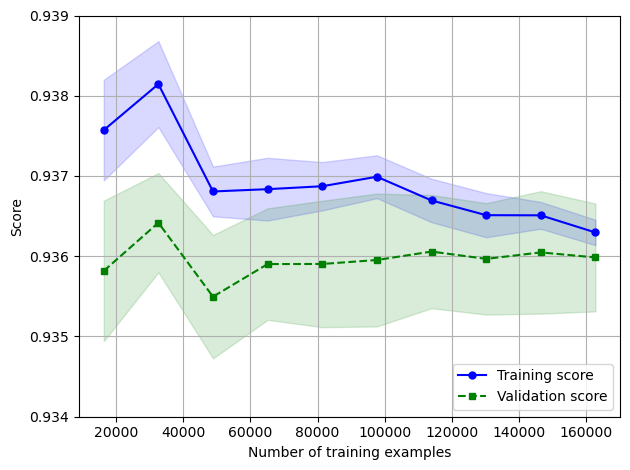

In [33]:
# Кривая обучения DecisionTreeRegressor
lear_curve(dtr, X_train, y_train, cv=5, ylim=[0.934, 0.939])

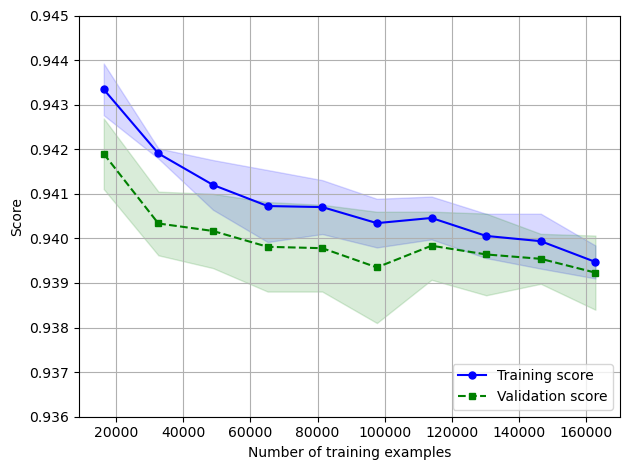

In [34]:
# Кривая обучения RandomForestRegressor
lear_curve(rfr, X_train, y_train, cv=5, ylim=[0.936, 0.945])

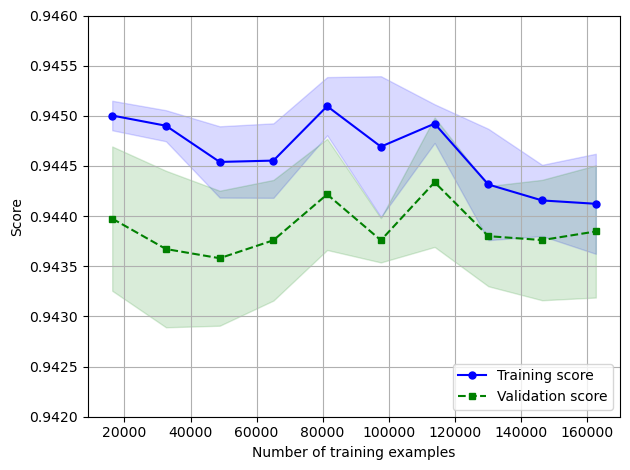

In [35]:
# Кривая обучения GradientBoostingRegressor
lear_curve(gbr, X_train, y_train, cv=5, ylim=[0.942, 0.946])

График модели GradientBoostingRegressor показывает наилучшую эффективность, более качественное обучение на данных параметрах.

In [36]:
def checking(s, est, X_train, y_train, cv=10):   
    # Метод перекрестной проверки для оценки результатов обучения
    scores = cross_val_score(
        est, 
        X_train, 
        y_train, 
        cv=cv
        )
    print(f'[{s}]: Mean cross-validation score: {round(scores.mean(), 4)}')
    print(f'{scores}')  
    # Метод KFlold для перекрестной проверки
    kfold = KFold(n_splits=cv, shuffle=True)
    kf_cv_scores = cross_val_score(
        est, 
        X_train, 
        y_train, 
        cv=kfold
    )
    print(f'[{s}]: K-fold CV average score: {round(kf_cv_scores.mean(), 4)}')
    print(f'{kf_cv_scores}')

Значение метрик

In [37]:
# DecisionTreeRegressor
checking('DecisionTreeRegressor', dtr, X_train, y_train, 5)
# RandomForestRegressor
checking('RandomForestRegressor', rfr, X_train, y_train, 5)
# GradientBoostingRegressor
checking('GradientBoostingRegressor', gbr, X_train, y_train, 5)

[DecisionTreeRegressor]: Mean cross-validation score: 0.936
[0.93642469 0.93633758 0.93679336 0.93513067 0.93523771]
[DecisionTreeRegressor]: K-fold CV average score: 0.936
[0.93652317 0.93569473 0.9353828  0.93577398 0.93650949]
[RandomForestRegressor]: Mean cross-validation score: 0.9392
[0.93938795 0.94014621 0.94006082 0.93804791 0.93851601]
[RandomForestRegressor]: K-fold CV average score: 0.9391
[0.93995858 0.93989881 0.93923462 0.93811497 0.93811567]
[GradientBoostingRegressor]: Mean cross-validation score: 0.9438
[0.94375432 0.94450008 0.94469794 0.94305114 0.94323158]
[GradientBoostingRegressor]: K-fold CV average score: 0.9441
[0.9435632  0.94444463 0.94499349 0.94397689 0.94329684]


##### Оптимизация гиперпараметров модели
За основу возмем библиотеку OPTUNA, а модель GradientBoostingRegressor

In [38]:
# Оптимизация гиперпараметров OPTUNA
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 50, 290, 20)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20, 1)
    min_samples_split = trial.suggest_int('min_samples_split', 10, 20, 1) 
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1, step=0.1)

    # создаем модель
    model = GradientBoostingRegressor(
      n_estimators=n_estimators,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      min_samples_split=min_samples_split,
      learning_rate=learning_rate,
      random_state=RANDOM_NUM
      )
    
    # обучаем модель
    model.fit(X_train, y_train)
    #score = metrics.mean_squared_error(y_train, model.predict(X_train))
    score = round(model.score(X_test, y_test), 4)
    return score
  
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize")
study.optimize(optuna_rf, n_trials=10)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("Метрика на обучающем наборе: {:.4f}".format(study.best_value))

[I 2023-02-16 08:26:57,371] A new study created in memory with name: GradientBoostingRegressor


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-02-16 08:30:58,786] Trial 0 finished with value: 0.9879 and parameters: {'n_estimators': 290, 'max_depth': 13, 'min_samples_leaf': 11, 'min_samples_split': 17, 'learning_rate': 0.4}. Best is trial 0 with value: 0.9879.
[I 2023-02-16 08:31:31,779] Trial 1 finished with value: 0.9884 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 19, 'min_samples_split': 17, 'learning_rate': 0.7000000000000001}. Best is trial 0 with value: 0.9879.
[I 2023-02-16 08:33:37,910] Trial 2 finished with value: 0.9887 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_leaf': 7, 'min_samples_split': 17, 'learning_rate': 0.1}. Best is trial 0 with value: 0.9879.
[I 2023-02-16 08:35:51,704] Trial 3 finished with value: 0.9869 and parameters: {'n_estimators': 170, 'max_depth': 12, 'min_samples_leaf': 15, 'min_samples_split': 11, 'learning_rate': 0.8}. Best is trial 3 with value: 0.9869.
[I 2023-02-16 08:38:53,871] Trial 4 finished with value: 0.9839 and parameters:

Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 28, 'min_samples_leaf': 3, 'min_samples_split': 11, 'learning_rate': 0.9}
Метрика на обучающем наборе: 0.9802


##### Формирование модели с оптимальными параметрами

In [39]:
# GradientBoostingRegressor на наилучших гиперпараметрах
params = {'n_estimators':study.best_params['n_estimators'],
          'max_depth':study.best_params['max_depth'],
          'criterion':'squared_error',
          'learning_rate':study.best_params['learning_rate'],
          'min_samples_leaf':study.best_params['min_samples_leaf'],
          'min_samples_split':study.best_params['min_samples_split'],
          'random_state':RANDOM_NUM
          }
gbr_best_param = GradientBoostingRegressor(**params)
gbr_best_param.fit(X_train, y_train)
 
gbr_best_param_train_pred  = gbr_best_param.predict(X_train)
gbr_best_param_test_pred  = gbr_best_param.predict(X_test)

Значение метрик на наилучших параметрах

In [40]:
print_metrics(y_train, gbr_best_param_train_pred, y_test, gbr_best_param_test_pred)

R^2 Train:1.0 Test:0.9803
MAE Train:0.0007 Test:0.0143
MSE Train:0.0 Test:0.001
RMSE Train:0.0016 Test:0.0323


##### Поэтапная автоматизация (Pipeline)

In [41]:
X_pipe = dff.drop(cols, axis = 1)
y_pipe = dff['action']

X_train_pipe, X_test_pipe, y_train_pipe, y_test_pipe = train_test_split(
    X_pipe, y_pipe,
    test_size=0.2, 
    random_state=RANDOM_NUM
    )

# GradientBoostingRegressor на наилучших гиперпараметрах
params = {'n_estimators':study.best_params['n_estimators'],
          'max_depth':study.best_params['max_depth'],
          'criterion':'squared_error',
          'learning_rate':study.best_params['learning_rate'],
          'min_samples_leaf':study.best_params['min_samples_leaf'],
          'min_samples_split':study.best_params['min_samples_split'],
          'random_state':RANDOM_NUM
          }

scaler = preprocessing.MinMaxScaler()
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
model = GradientBoostingRegressor(**params)

pipeline = Pipeline(
    steps=[('scaler', scaler),
           ('t', trans),
           ('model', model)])
%time pipeline.fit(X_train_pipe.values, y_train_pipe)

pline_train_pred = pipeline.predict(X_train_pipe.values)
pline_test_pred = pipeline.predict(X_test_pipe.values)


CPU times: total: 4min 36s
Wall time: 4min 38s


Значение метрик

In [42]:
print_metrics(y_train_pipe, pline_train_pred, y_test_pipe, pline_test_pred)

R^2 Train:1.0 Test:0.9802
MAE Train:0.0012 Test:0.0226
MSE Train:0.0 Test:0.0026
RMSE Train:0.0026 Test:0.0514


##### Построим графики предсказаний для ряда "кривизны"

In [43]:
prof = ['nomen_23А', 
        'nomen_Т70А', 
        'nomen_Т82А', 
        'nomen_Т89А', 
        'nomen_Т89В', 
        'nomen_Т90В']

def act(est, s, curva, ind):           
    d1 = dff[dff[s] == 1]
    act = []
    if ind == 0: 
        a, b, c, d, e, f = 1, 0, 0, 0, 0, 0
    if ind == 1: 
        a, b, c, d, e, f = 0, 1, 0, 0, 0, 0
    if ind == 2: 
        a, b, c, d, e, f = 0, 0, 1, 0, 0, 0
    if ind == 3: 
        a, b, c, d, e, f = 0, 0, 0, 1, 0, 0        
    if ind == 4: 
        a, b, c, d, e, f = 0, 0, 0, 0, 1, 0
    if ind == 5: 
        a, b, c, d, e, f = 0, 0, 0, 0, 0, 1
        
    for x in curva:
        row = [x,
               d1['C'].mean(),
               d1['Si'].mean(),
               d1['V'].mean(),
               d1['Mn'].mean(),
               a, b, c, d, e, f]
        row = np.asarray(row).reshape((1, len(row)))
        yhat = est.predict(row)
        act.append(yhat[0])

    return act, s

<AxesSubplot: xlabel='curvature', ylabel='action'>

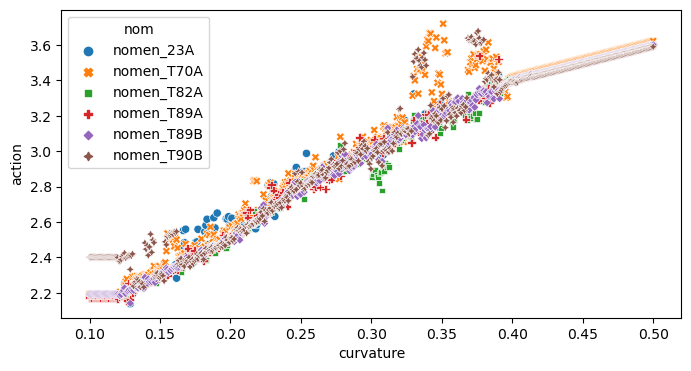

In [45]:
curvature = list(np.linspace(0.1, 0.5, 500, dtype=float))
ddff = pd.DataFrame(columns =  ['curvature', 'action', 'nom'])

for index, value in enumerate(prof):
    action = act(pipeline, value, curvature, index)       
    datf = pd.DataFrame(
        {
            'curvature': curvature,
            'action': action[0],
            'nom': action[1]
        }
    )
    ddff = pd.concat([ddff, datf], ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
sns.scatterplot(
    data=ddff,
    x='curvature', 
    y='action', 
    hue='nom',
    style='nom',
    ax=axes
    )

## 7. Вывод модели в продакшен

1. Сериализуем модель
2. Формируем сервис на основании полученной модели.
3. Формируем скрипт в python, который будет выполнятся циклический и контролировать смену номенклатуры, на основании данных из OPC сервера и считывать хим. состав конкретной плавки из базы данных PostgreSQL.
4. Набор данных отправляем в сервис (модель для предсказания).
5. Полученное значение возвращаем в OPC сервер (оборудование) для выполнения правки на данную величину.

Сериализуем модель

In [46]:
# Производим сериализацию модели
with open('apl_model_pipeline.pkl', 'wb') as output:
    pickle.dump(pipeline, output)

## ...

## Вывод:
В ходе данной работы получен следующий результат:
- получены и проанализированы даные файла кривизны профиля
- были выбраны и обучены модели машинного обучения
- из показаний метрик выбрана наилучная модель и обучена на наилучших гиперпараметрах
- модель выведена в продакшен для прохождения опытно промышленной эксплуатации.